## 1. Introduction ##

Now that you have been equipped with the skills and the tools to use location data to explore a geographical location, over the course of two weeks, you will have the opportunity to be as creative as you want and come up with an idea to leverage the Foursquare location data to explore or compare neighborhoods or cities of your choice or to come up with a problem that you can use the Foursquare location data to solve. If you cannot think of an idea or a problem, here are some ideas to get you started:

1. In Module 3, we explored New York City and the city of Toronto and segmented and clustered their neighborhoods. Both cities are very diverse and are the financial capitals of their respective countries. One interesting idea would be to compare the neighborhoods of the two cities and determine how similar or dissimilar they are. Is New York City more like Toronto or Paris or some other multicultural city? I will leave it to you to refine this idea.
2. In a city of your choice, if someone is looking to open a restaurant, where would you recommend that they open it? Similarly, if a contractor is trying to start their own business, where would you recommend that they setup their office?

These are just a couple of many ideas and problems that can be solved using location data in addition to other datasets. No matter what you decide to do, make sure to provide sufficient justification of why you think what you want to do or solve is important and why would a client or a group of people be interested in your project.

## 1.1. Business problem ##

NYC is a one of a biggest megapolises in the world with a vivid and constantly changing demand for a restaurant market. Since it's a biggest bussines center it demands a wide choose of fine dinning places. This project will be used in order to spot out a place where supposedly will make sense to open a next haute cuisine place. 
The project will allow to check the map for possible competition and their rating and decide whether or not opening a new French restaurant is a viable idea.


## 1.2. Target audience ## 

This project will be interested for anyone who will be willing to open a restaurant in NYC or whos is offering any other types of business solution around catering business.

## 2. Data section ## 

1. Fousquare API will be used in order to get list of requested properties with all possible specification for the requested analysys. 
2. https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm - goverment's NYC neighborhoods boundaries whic will be used in order to separate the neighborhoods 
3. https://cocl.us/new_york_dataset - list of NYC neighborhoods and geo locations for plotting on the map 

## 3. Methodology ## 

1. Function preparation before data collection
2. Data collection
3. Data cleaning and modeling
4. Analysis of outputs

### Environment set up


In [ ]:
from bs4 import BeautifulSoup
import requests   
import lxml       
import numpy as np
import pandas as pd

#Setting up the environment
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

### Functions preparation 


In [7]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [8]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '################################' # changed my Foursquare ID
    CLIENT_SECRET = '######################################' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

In [9]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '##########################' # i have changed the id with ##
    CLIENT_SECRET = '##########################' # i have changed the secret with ##
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [10]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

### Data collection and preparation

In [11]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
new_york_data.shape

(306, 4)

In [13]:
# prepare neighborhood list that contains French resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
FRN=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    french_resturants=venues[venues['Category']=='French Restaurant']   
    print('(',count,'/',len(new_york_data),')','French Resturants in '+Neighborhood+', '+Borough+':'+str(len(french_resturants)))
    for resturant_detail in french_resturants.values.tolist():
        id, name , category=resturant_detail
        FRN = FRN.append({'Borough': Borough,
                          'Neighborhood': Neighborhood, 
                          'ID': id,
                          'Name' : name
                          }, ignore_index=True)
    count+=1

done
( 1 / 306 ) French Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) French Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) French Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) French Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) French Resturants in Riverdale, Bronx:0
done
( 6 / 306 ) French Resturants in Kingsbridge, Bronx:0
done
( 7 / 306 ) French Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) French Resturants in Woodlawn, Bronx:0
done
( 9 / 306 ) French Resturants in Norwood, Bronx:0
done
( 10 / 306 ) French Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) French Resturants in Baychester, Bronx:0
done
( 12 / 306 ) French Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) French Resturants in City Island, Bronx:1
done
( 14 / 306 ) French Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) French Resturants in University Heights, Bronx:0
done
( 16 / 306 ) French Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) French Resturants in Ford

In [14]:
FRN.head()

,Borough,Neighborhood,ID,Name
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK
1,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin
3,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock
4,Brooklyn,Windsor Terrace,4aee2d5cf964a520b7d221e3,Le P'tit Paris Bistro


In [15]:
FRN.shape

(76, 4)

### Visualisation and modeling


In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

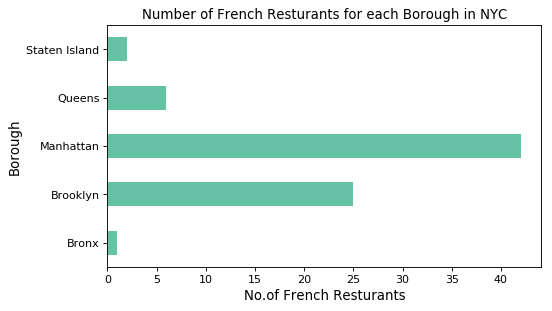

In [35]:
plt.figure(figsize=(7,4), dpi = 80)
# title
plt.title('Number of French Resturants for each Borough in NYC')
#On x-axis
plt.xlabel('No.of French Resturants', fontsize = 12)
#On y-axis
plt.ylabel('Borough', fontsize=12)
#giving a bar plot
FRN.groupby('Borough')['ID'].count().plot(kind='barh', colormap='Set2')
#displays the plot
plt.show()

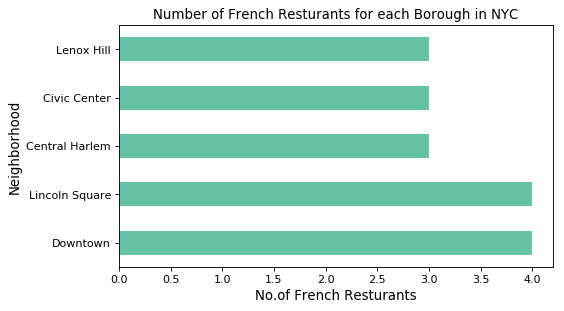

In [37]:
plt.figure(figsize=(7,4), dpi = 80)
# title
plt.title('Number of French Resturants for each Borough in NYC')
#On x-axis
plt.xlabel('No.of French Resturants', fontsize = 12)
#On y-axis
plt.ylabel('Neighborhood', fontsize=12)
#giving a bar plot
FRN.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='barh', colormap='Set2')
#displays the plot
plt.show()

In [39]:
FRN[FRN['Neighborhood']=='Floral Park']


,Borough,Neighborhood,ID,Name


In [40]:
# prepare neighborhood list that contains French resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
FRSNY=pd.DataFrame(columns=column_names)
count=1

for row in FRN.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id, name, likes, rating, tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id, name, likes, rating, tips=[0]*5
    print('(',count,'/',len(FRN),')','processed')
    FRSNY = FRSNY.append({'Borough': Borough,
                 'Neighborhood': Neighborhood, 
                 'ID': id,
                 'Name' : name,
                 'Likes' : likes,
                 'Rating' : rating,
                 'Tips' : tips
                }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  4d7aa83ee540f04d66ba16dc  Bistro SK     13     7.5     7
( 1 / 76 ) processed
                         ID           Name  Likes  Rating  Tips
0  58fd34584382ab70ad90083e  Chez Ma Tante    211     8.8    58
( 2 / 76 ) processed
                         ID      Name  Likes  Rating  Tips
0  4bcf1883c564ef3ba33beff0  Le Gamin    158     7.8    73
( 3 / 76 ) processed
                         ID        Name  Likes  Rating  Tips
0  4e7d174cb6340a4da75a2cca  Le Paddock    135     8.7    56
( 4 / 76 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4aee2d5cf964a520b7d221e3  Le P'tit Paris Bistro     55     7.5    32
( 5 / 76 ) processed
                         ID       Name  Likes  Rating  Tips
0  50b99e4ae4b0c22ba9633dfd  Mominette    340     8.4    80
( 6 / 76 ) processed
                         ID            Name  Likes  Rating  Tips
0  5003007de4b06d50188aa593  Le Paris Dakar    145     8.

KeyError: 'venue'

In [41]:
FRSNY.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,13,7.5,7
1,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante,211,8.8,58
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,158,7.8,73
3,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock,135,8.7,56
4,Brooklyn,Windsor Terrace,4aee2d5cf964a520b7d221e3,Le P'tit Paris Bistro,55,7.5,32


In [42]:
FRSNY.shape

(50, 7)

In [43]:
FRN.shape

(76, 4)

In [44]:
FRSNY.to_csv('FRSNY.csv', index=False)


In [45]:
FRSNY_csv=pd.read_csv('FRSNY.csv')

In [46]:
FRSNY_csv.shape

(50, 7)

In [47]:
FRSNY_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,13,7.5,7
1,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante,211,8.8,58
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,158,7.8,73
3,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock,135,8.7,56
4,Brooklyn,Windsor Terrace,4aee2d5cf964a520b7d221e3,Le P'tit Paris Bistro,55,7.5,32


In [48]:
FRSNY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


In [49]:
FRSNY['Likes']=FRSNY['Likes'].astype('float64')

In [50]:
FRSNY['Tips']=FRSNY['Tips'].astype('float64')

In [51]:
FRSNY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [52]:
# Resturant with maximum Likes
FRSNY.iloc[FRSNY['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  North Side
ID              4554c3b0f964a520113d1fe3
Name                            Juliette
Likes                                775
Rating                               8.4
Tips                                 274
Name: 22, dtype: object

In [53]:
# Resturant with maximum Rating
FRSNY.iloc[FRSNY['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                   Chinatown
ID              57583641498e90001a32e13e
Name                           Le Coucou
Likes                                394
Rating                               9.3
Tips                                  90
Name: 25, dtype: object

In [54]:
# Resturant with maximum Tips
FRSNY.iloc[FRSNY['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood              Lincoln Square
ID              3fd66200f964a520bee91ee3
Name                        Jean-Georges
Likes                                553
Rating                               8.9
Tips                                 283
Name: 41, dtype: object

In [55]:
NNS=FRSNY.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
NNS.columns=['Neighborhood','Average Rating']

In [56]:
NNS.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
19,Little Italy,9.30
24,Soho,9.15
12,East Harlem,9.10
25,South Side,9.10
6,Chelsea,9.00
16,Greenwich Village,9.00
20,Lower East Side,8.90
7,Chinatown,8.90
29,Yorkville,8.80
22,North Side,8.75


In [57]:
NBS=FRSNY.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
NBS.columns=['Borough','Average Rating']

In [58]:
NBS.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.740000
1,Brooklyn,8.383333
0,Bronx,7.500000


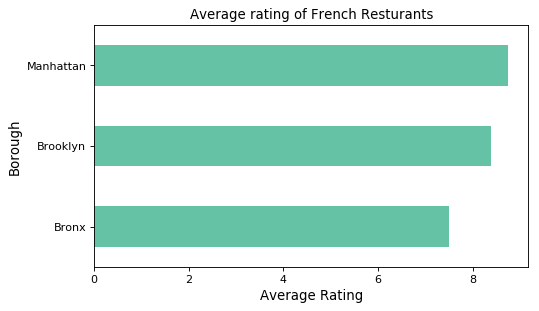

In [60]:
plt.figure(figsize=(7,4), dpi = 80)
# title
plt.title('Average rating of French Resturants')
#On x-axis
plt.xlabel('Average Rating', fontsize = 12)
#On y-axis
plt.ylabel('Borough', fontsize=12)
#giving a bar plot
FRSNY.groupby('Borough').mean()['Rating'].plot(kind='barh', colormap='Set2')
#displays the plot
plt.show()

In [61]:
NNS=NNS[NNS['Average Rating']>=9.0]

In [62]:
NNS

,Neighborhood,Average Rating
6,Chelsea,9.00
12,East Harlem,9.10
16,Greenwich Village,9.00
19,Little Italy,9.30
24,Soho,9.15
25,South Side,9.10


In [63]:
NNS=pd.merge(NNS,new_york_data, on='Neighborhood')

In [64]:
NNS=NNS[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [65]:
NNS

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,9.00
1,Staten Island,Chelsea,40.594726,-74.189560,9.00
2,Manhattan,East Harlem,40.792249,-73.944182,9.10
3,Manhattan,Greenwich Village,40.726933,-73.999914,9.00
4,Manhattan,Little Italy,40.719324,-73.997305,9.30
5,Manhattan,Soho,40.722184,-74.000657,9.15
6,Brooklyn,South Side,40.710861,-73.958001,9.10


In [66]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [73]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in NNS[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='gold',
            fill=True,
            fill_color='green',
            fill_opacity=0.6
        )
    )

In [74]:
NNS['Label']=NNS['Neighborhood']+', '+NNS['Borough']+'('+NNS['Average Rating'].map(str)+')'

In [75]:
# add pop-up text to each marker on the map
for lat, lng, label in NNS[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## 4. Result and Conclusion ##

So as we can see there are a two possible oportunity for the mentioned bussines model on Manhattan and Staten Island. And if on Staten Island we see a lot of possible places and districts for a new opening comparing with just one high rated French restrans. In other hand on Manhattan there are 5 high level places which could mean that a demand there is on a growing level and it could be a smart investition. 


## 6. Next Developments ## 

In order to make this analysys nore predictive and create straight conclusion it's better to add to the report analysys of rental rates and avrage cheque in the mentioned places. That's will help to understan why there a 5 places on Manhattan and just one on Staten Island. Probably there are no demand but also it could be just not the aim audience for this type of restrants. 